# **Bi-directional LSTM Model for Stock Price Prediction**
In this project, I perform a time series prediction for stock prices using a bi-directional *Long Short Term Memory (LSTM)* regressor.

# **Part 1: Data Loading and Pre-processing**

## 1.0 Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1.1 Data Loading
[S&P 500](https://www.kaggle.com/camnugent/sandp500)

In [ ]:
from google.colab import drive
drive.mount('ggdrive')

In [ ]:
#!wget https://raw.githubusercontent.com/tonylaioffer/stock-prediction-lstm-using-keras/master/data/sandp500/all_stocks_5yr.csv
#df = pd.read_csv("./all_stocks_5yr.csv")

df = pd.read_csv("./ggdrive/My Drive/dataSet/all_stocks_5yr.csv")
df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d').dt.round('d')
df.sort_values(by=['Name', 'date'], inplace=True)

In [ ]:
df.head()

date   open   high    low  close   volume Name
71611 2013-02-08  45.07  45.35  45.00  45.08  1824755    A
71612 2013-02-11  45.17  45.18  44.45  44.60  2915405    A
71613 2013-02-12  44.81  44.95  44.50  44.62  2373731    A
71614 2013-02-13  44.81  45.24  44.68  44.75  2052338    A
71615 2013-02-14  44.72  44.78  44.36  44.58  3826245    A

## 1.2 Exploratory Data Analysis

### 1.2.1 Basic Information

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 619040 entries, 71611 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619040 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619032 non-null  float64       
 3   low     619032 non-null  float64       
 4   close   619040 non-null  float64       
 5   volume  619040 non-null  int64         
 6   Name    619040 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 37.8+ MB


In [ ]:
df.describe()

open           high            low          close        volume
count  619029.000000  619032.000000  619032.000000  619040.000000  6.190400e+05
mean       83.023334      83.778311      82.256096      83.043763  4.321823e+06
std        97.378769      98.207519      96.507421      97.389748  8.693610e+06
min         1.620000       1.690000       1.500000       1.590000  0.000000e+00
25%        40.220000      40.620000      39.830000      40.245000  1.070320e+06
50%        62.590000      63.150000      62.020000      62.620000  2.082094e+06
75%        94.370000      95.180000      93.540000      94.410000  4.284509e+06
max      2044.000000    2067.990000    2035.110000    2049.000000  6.182376e+08

In [ ]:
df.isna().sum()

date       0
open      11
high       8
low        8
close      0
volume     0
Name       0
dtype: int64

In [ ]:
df[df.isna().any(axis=1)]

date  open   high    low     close   volume  Name
82949  2017-07-26   NaN    NaN    NaN   69.0842        3   BHF
165734 2015-07-17   NaN  88.76  88.24   88.7200  2056819   DHR
165857 2016-01-12   NaN    NaN    NaN   88.5500        0   DHR
205076 2015-07-17   NaN  48.49  47.85   47.9200  1246786    ES
239832 2016-07-01   NaN    NaN    NaN   49.5400        0   FTV
434379 2015-07-17   NaN  47.31  46.83   46.9900  1229513     O
434502 2016-01-12   NaN    NaN    NaN   52.4300        0     O
478594 2015-06-09   NaN    NaN    NaN  526.0900    12135  REGN
558213 2016-04-07   NaN    NaN    NaN   41.5600        0    UA
581906 2015-05-12   NaN    NaN    NaN  124.0800   569747  VRTX
598236 2015-06-26   NaN    NaN    NaN   61.9000      100   WRK

In [ ]:
df.nunique()

date        1259
open       49715
high       81499
low        82354
close      51151
volume    586441
Name         505
dtype: int64

In [ ]:
sum(df.groupby(['Name', 'date']).size() > 1)

0

### 1.2.2 Exploratory Data Analysis

We have 505 stock data over 1259 days.


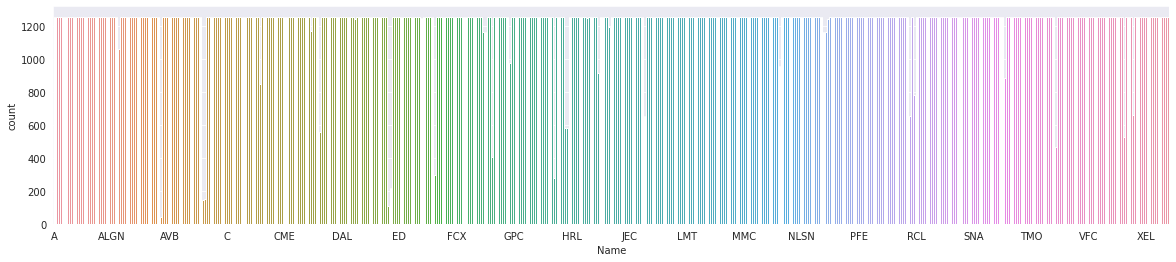

In [ ]:
fig = plt.figure(figsize=[20, 4])
ax = sns.countplot(x='Name', data=df)
locs, labels = plt.xticks()
locs = locs[:: (len(locs) // (20 - 1))]
labels = labels[:: (len(labels) // (20 - 1))]
plt.xticks(locs, labels)
print(f"We have {df.Name.nunique()} stock data over {df.date.nunique()} days.")

#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

Name
AAPL    1259
SWKS    1259
dtype: int64


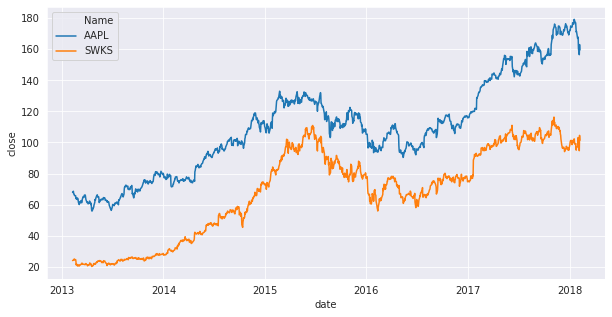

In [ ]:
mydf = df[df.Name.isin(['SWKS', 'AAPL'])]
print(mydf.groupby('Name').size())

fig = plt.figure(figsize=[10, 5])
ax = sns.lineplot(x='date', y='close', data=mydf, markers=True, hue='Name')
#locs, labels = plt.xticks()
#print(labels[3])
#locs = locs[:: (len(locs) // (10 - 1))]
#labels = labels[:: (len(labels) // (10 - 1))]
#plt.xticks(locs, labels)
#print(locs, labels)

## 1.3 Pre-processing

### 1.3.1 Extract data and scale them

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))

swks_close = df.loc[df['Name']=='SWKS', ['close']].to_numpy()
swks_close = sc.fit_transform(swks_close)
print(swks_close.shape)

(1259, 1)


### 1.3.2 Cutting our time series into sequences

In [ ]:
def Xy_ngram(stock, ngram, y_len=1):
  X, y = [], []
  for i in range(stock.shape[0] - ngram):
    X.append(stock[i:(i + ngram), 0])
    y.append(stock[(i + ngram + 1 - y_len):(i + ngram + 1), 0])
  return np.array(X), np.array(y)

X, y = Xy_ngram(swks_close, ngram=7, y_len=1)
print(X.shape, y.shape)
#print("{}\n{}".format(X[0], y[0]))

(1252, 7) (1252, 1)


### 1.3.3 Spliting sequences into different data, for example, into training and testing data

In [ ]:
def dataSplit(X, y, *probs):
  assert sum(probs) < 1
  n = X.shape[0]
  n0 = n1 = 0
  data = []
  for prob in probs:
    n1 += int(prob * n)
    data.append([X[n0:n1, :], y[n0:n1, :]])
    n0 = n1
  data.append([X[n1:n, :], y[n1:n, :]])
  return data

data = dataSplit(X, y, 0.8)
print(data[0][0].shape, data[0][1].shape)
print(data[1][0].shape, data[1][1].shape)

(1001, 7) (1001, 1)
(251, 7) (251, 1)


### 1.3.4 How to view Data?
we can treat X as
- a tensor of size = (1, X.shape[0], ngram) -- viewAngle = 0: all data as 1 timeseries
- or a tensor of size = (X.shape[0], ngram, 1) -- viewAngle = 1: each segment as 1 timeseries

In [ ]:
def dataView(X_data, y_data, viewAngle=0):
  a, b = X_data.shape
  if viewAngle == 0:
    X_data = X_data.reshape(1, a, b)
    y_data = y_data.reshape(1, a, -1)
  elif viewAngle == 1:
    X_data = X_data.reshape(a, b, 1)
    y_data = y_data.reshape(a, -1, 1)
  else:
    raise ValueError("viewAngle must be 0 or 1")
  return X_data, y_data

X_train, y_train = dataView(*(data[0]), 1)
print(X_train.shape, y_train.shape)

(1001, 7, 1) (1001, 1, 1)


# **Part 2: Build a bi-directional LSTM regression model and related helper functions**
Having created input/output pairs out of our time series and cut this into training/testing sets, we can now begin setting up our RNN.  We use Keras to quickly build a two hidden layer RNN of the following specifications

- layer 1 uses an LSTM module with 3 layers
- layer 2 uses a fully connected layer
- the 'mean_squared_error' loss should be used

## 2.0 Check available device

In [ ]:
import torch
import torch.nn as nn

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print(f"Working on {device} of {torch.cuda.get_device_name(device)}")
else:
  device = torch.device("cpu")
  print(f"Working on {device}")

Working on cuda:0 of Tesla T4


## 2.1 BiLSTM model

In [ ]:
class Bi_LSTM(nn.Module):
  def __init__(self, d_in, d_h, n_layers, d_out, bidirection=True, dropout=0.5):
    super(Bi_LSTM, self).__init__()

    # architecture parameters
    self.d_h = d_h
    self.d_out = d_out
    self.n_layers = n_layers
    self.n_direct = bidirection + 1

    # layers
    self.lstm = nn.LSTM(input_size=d_in, \
                        hidden_size=d_h, \
                        num_layers=n_layers, \
                        bidirectional=bidirection, \
                        batch_first=True, \
                        dropout=dropout)
    self.dropout = nn.Dropout(dropout)
    self.fc = nn.Linear(self.n_direct * d_h, d_out)
  
  def forward(self, x, hidden=None):
    batch_size = x.size(0)

    # whether to initial hidden
    if hidden == None:
      hidden = self.init_hidden(batch_size)
    else:
      assert len(hidden) == 2
      hidden_, cell_ = hidden
      #print(hidden_.size())
      #print(cell_.size())
      #print(self.n_direct, self.n_layers, batch_size, self.d_h)
      assert hidden_.size() == cell_.size()
      assert hidden_.size() == (self.n_direct * self.n_layers, \
                                batch_size, \
                                self.d_h)
      if self.n_direct == 2:  # set reversed part to zeros
        hidden_[self.n_layers:, :, :] = 0.0
        cell_[self.n_layers:, :, :] = 0.0
    
    # forward propagation
    out, hidden = self.lstm(x, hidden)
    #print(out.size())
    out = out.contiguous().view(-1, self.n_direct * self.d_h)

    out = self.dropout(out)
    out = self.fc(out)
    out = out.view(batch_size, -1, self.d_out)

    return out, hidden

  def init_hidden(self, batch_size):
    hidden_ = torch.zeros(self.n_direct * self.n_layers, \
                          batch_size, self.d_h, device=device)
    cell_ = torch.zeros(self.n_direct * self.n_layers, \
                        batch_size, self.d_h, device=device)
    return hidden_, cell_

### Check dimension (only for debugging)

In [ ]:
if False:
  param0 = {'d_in': 6, 'd_h': 4, 'n_layers': 3, 'd_out': 1}
  model = Bi_LSTM(**param0).to(device)
  for param in model.named_parameters():
    print(param)
  X = torch.from_numpy(np.arange(60).reshape(2,5,6)).float().to(device)
  out, hidden = model.forward(X)
  out.size(), hidden[0].size(), hidden[1].size()

## 2.2 Train Model Function

In [ ]:
import copy

def train_model(model, train_data, valid_data, epochs, criterion, optimizer, clip, viewAngle):
  train_loss = []
  valid_loss = []
  print_every = epochs // 10
  loss_v_min = float('Inf')

  for epoch in range(epochs):
    model.train()
    out, hidden = model.forward(train_data[0])
    loss = criterion(out, train_data[1])
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()

    model.eval()
    if viewAngle == 1:
      hidden = None
    out_v, _ = model.forward(valid_data[0], hidden)
    loss_v = criterion(out_v, valid_data[1])
    if loss_v.item() < loss_v_min:
      loss_v_min = loss_v.item()
      best_model_wt = copy.deepcopy(model.state_dict())

    train_loss.append(loss.item())
    valid_loss.append(loss_v.item())

    if epoch % print_every == 0:
      print("epoch {}/{}: \n\ttrain loss: {:.4f}\n\tvalid loss: {:.4f}".format(epoch,\
                                epochs, loss.item(), loss_v.item()))
  model.load_state_dict(best_model_wt)
  return train_loss, valid_loss, model, loss_v_min

## 2.3 Visualization of the training history

In [ ]:
def visual(train_loss, valid_loss, modelNM):
  fig = plt.figure(figsize=(10, 4))
  plt.plot(train_loss, label="Training Data")
  plt.plot(valid_loss, label="Validation Data")
  plt.yscale('log')
  plt.legend()

  plt.xlabel("epoch")
  plt.ylabel("MSE loss of scaled price")
  plt.title("Training History of {}".format(modelNM), fontsize=16)

## 2.4 Evaluate model over testing data

In [ ]:
def evalTest(model, train_data, valid_data, test_data, criterion, stock_seq, \
             ngram, stockNM, stockCol, modelNM, viewAngle, scaleRange):
  model.eval()
  out, hidden = model.forward(train_data[0])
  loss = criterion(out, train_data[1])
  rmse = torch.sqrt(loss).cpu().detach().numpy() * scaleRange
  if viewAngle == 1:
    out = out[:, -1, :]
  out = out.cpu().detach().numpy().reshape(-1, 1)
  out_sz = out.shape[0]

  if viewAngle == 1:
    hidden = None
  out_v, hidden = model.forward(valid_data[0], hidden)
  loss_v = criterion(out_v, valid_data[1])
  rmse_v = torch.sqrt(loss_v).cpu().detach().numpy() * scaleRange
  if viewAngle == 1:
    out_v = out_v[:, -1, :]
  out_v = out_v.cpu().detach().numpy().reshape(-1, 1)
  out_v_sz = out_v.shape[0]

  if viewAngle == 1:
    hidden = None
  out_t, _ = model.forward(test_data[0], hidden)
  loss_t = criterion(out_t, test_data[1])
  rmse_t = torch.sqrt(loss_t).cpu().detach().numpy() * scaleRange
  if viewAngle == 1:
    out_t = out_t[:, -1, :]
  out_t = out_t.cpu().detach().numpy().reshape(-1, 1)
  out_t_sz = out_t.shape[0]

  fig = plt.figure(figsize=(10, 4))
  plt.plot(sc.inverse_transform(stock_seq), color='k')
  n0, n1 = ngram, ngram + out_sz
  plt.plot(np.arange(n0, n1, 1), sc.inverse_transform(out), color='b')
  n0, n1 = n1, n1 + out_v_sz
  plt.plot(np.arange(n0, n1, 1), sc.inverse_transform(out_v), color='g')
  n0, n1 = n1, n1 + out_t_sz
  plt.plot(np.arange(n0, n1, 1), sc.inverse_transform(out_t), color='r')

  plt.xlabel('day')
  plt.ylabel("{} price of {} stock".format(stockCol, stockNM))
  plt.title("Performance of {}".format(modelNM), fontsize=16)
  plt.legend(['original series',\
              'training fit (RMSE: {:.4f})'.format(rmse[0]),\
              'validation fit (RMSE: {:.4f})'.format(rmse_v[0]),\
              'testing fit (RMSE: {:.4f})'.format(rmse_t[0])])

## 2.5 Our RMSE loss function (Deprecated)

In [ ]:
class RMSELoss(nn.Module):
    def __init__(self, scaleRange=1.0):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()
        self.register_buffer('scaleRange', torch.tensor([scaleRange], requires_grad=False).float())
        
    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat, y) + 1e-8) * self.scaleRange
        return loss

# Step 3: Experiments

## 3.0 Wrapper functions

### 3.0.1 Experimental data function

In [ ]:
def expData(df = df,
            stockNM = 'SWKS',
            stockCol = 'close',
            ngram = 7,
            y_len = 1,
            p_split = (0.7, 0.15),
            viewAngle = 0):
  stock = df.loc[df['Name']==stockNM, [stockCol]].to_numpy()
  stock = sc.fit_transform(stock)
  myParas = {"stockNM": stockNM, "stockCol": stockCol, 
             "ngram": ngram, "y_len": y_len,
             "viewAngle": viewAngle, "scaleRange": sc.data_range_}
  X, y = Xy_ngram(stock, ngram, y_len)
  data = dataSplit(X, y, *p_split)
  exp_data = []
  for Xy in data:
    X_y = dataView(*Xy, viewAngle=viewAngle)
    exp_data.append([torch.from_numpy(z).float().to(device) for z in X_y])
    print(exp_data[-1][0].size(), exp_data[-1][1].size())
  return stock, exp_data, myParas

### 3.0.2 Objective Function

In [ ]:
criterion = nn.MSELoss()

def build_obj_func(stock_data,
                   d_h = 64,
                   n_layers = 3,
                   bidirect = False,
                   clip = 5):
  
  stock_seq = stock_data[0]
  train_data, valid_data, test_data = stock_data[1]
  stock_myParas = stock_data[2]

  d_in = train_data[0].size(2)
  d_out = train_data[1].size(2)

  NM = "Bi_LSTM" if bidirect else "LSTM"
  ngram = stock_myParas["ngram"]
  stockNM = stock_myParas["stockNM"] 
  stockCol = stock_myParas["stockCol"]
  viewAngle = stock_myParas["viewAngle"]
  scaleRange = stock_myParas["scaleRange"]

  # obj_func
  def obj_func(dropout, lr, epochs):
    epochs = int(round(epochs))

    lstm = Bi_LSTM(d_in, d_h, n_layers, d_out, bidirect, dropout).to(device)
    optimizer = torch.optim.Adam(lstm.parameters(), lr=lr)

    train_loss, valid_loss, lstm, loss_v_min = train_model(lstm, train_data, valid_data, epochs,\
                                                           criterion, optimizer, clip, viewAngle)
    modelNM = '"{} model with lr={:.4f}, dropout={:.2f}, epochs={}"'.format(NM, lr, dropout, epochs)
    visual(train_loss, valid_loss, modelNM)
    evalTest(lstm, train_data, valid_data, test_data, criterion, stock_seq,\
             ngram, stockNM, stockCol, modelNM, viewAngle, scaleRange)
    return -loss_v_min
  return obj_func

### 3.0.3 Install Bayesian Optimization package

In [ ]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=9d45923b5c21acd2979bd62b77b805823a1235e3f93035187d535ba5765d886c
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


## 3.1 Experiment 1: A first glance of the model's performance

### 3.1.1 "SWKS" stock with viewAngle = 0

In [ ]:
SWKSclose = expData(stockNM="SWKS")

torch.Size([1, 876, 7]) torch.Size([1, 876, 1])
torch.Size([1, 187, 7]) torch.Size([1, 187, 1])
torch.Size([1, 189, 7]) torch.Size([1, 189, 1])


### 3.1.2 LSTM model performance with fixed Hyper-parameters

epoch 0/300: 
	train loss: 0.1810
	valid loss: 0.2103
epoch 30/300: 
	train loss: 0.0105
	valid loss: 0.0048
epoch 60/300: 
	train loss: 0.0058
	valid loss: 0.0018
epoch 90/300: 
	train loss: 0.0050
	valid loss: 0.0013
epoch 120/300: 
	train loss: 0.0051
	valid loss: 0.0029
epoch 150/300: 
	train loss: 0.0045
	valid loss: 0.0012
epoch 180/300: 
	train loss: 0.0041
	valid loss: 0.0011
epoch 210/300: 
	train loss: 0.0042
	valid loss: 0.0022
epoch 240/300: 
	train loss: 0.0037
	valid loss: 0.0012
epoch 270/300: 
	train loss: 0.0030
	valid loss: 0.0009


-0.0008325430098921061

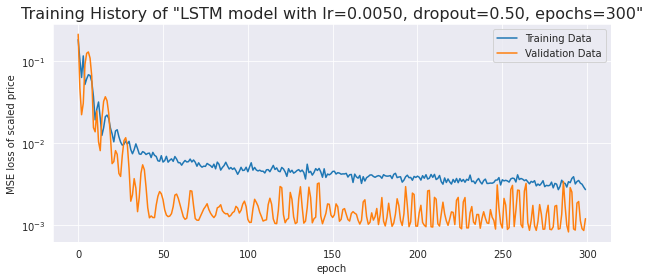

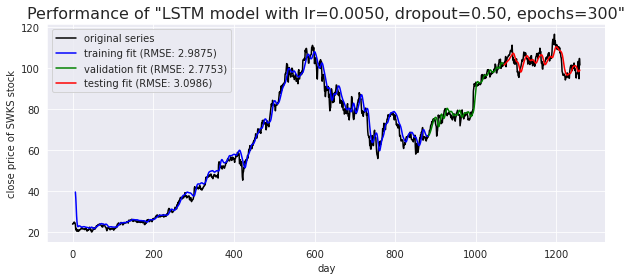

In [ ]:
obj_func = build_obj_func(SWKSclose)
obj_func(0.5, 0.005, 300)

### 3.1.3 BiLSTM model performance with fixed Hyper-parameters

epoch 0/300: 
	train loss: 0.1995
	valid loss: 0.1106
epoch 30/300: 
	train loss: 0.0051
	valid loss: 0.0020
epoch 60/300: 
	train loss: 0.0032
	valid loss: 0.0016
epoch 90/300: 
	train loss: 0.0026
	valid loss: 0.0022
epoch 120/300: 
	train loss: 0.0022
	valid loss: 0.0024
epoch 150/300: 
	train loss: 0.0020
	valid loss: 0.0022
epoch 180/300: 
	train loss: 0.0019
	valid loss: 0.0028
epoch 210/300: 
	train loss: 0.0016
	valid loss: 0.0022
epoch 240/300: 
	train loss: 0.0018
	valid loss: 0.0023
epoch 270/300: 
	train loss: 0.0015
	valid loss: 0.0023


-0.00150179339107126

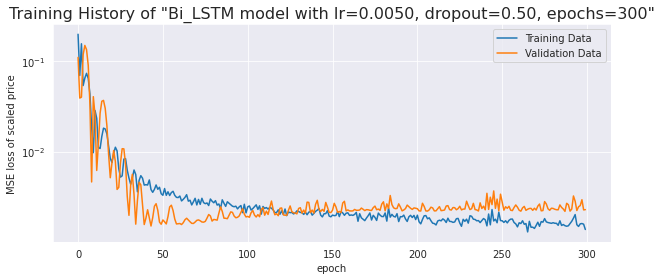

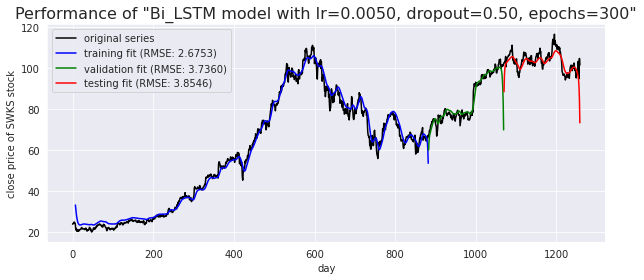

In [ ]:
obj_func = build_obj_func(SWKSclose, bidirect=True)
obj_func(0.5, 0.005, 300)

## 3.2 Experiment 2: Tune hyper-parameters using Bayesian Optimization method 

### 3.2.1 Tune Hyper-parameters for one-directional LSTM

|   iter    |  target   |  dropout  |  epochs   |    lr     |
-------------------------------------------------------------
epoch 0/295: 
	train loss: 0.3167
	valid loss: 0.3001
epoch 29/295: 
	train loss: 0.0071
	valid loss: 0.0016
epoch 58/295: 
	train loss: 0.0048
	valid loss: 0.0013
epoch 87/295: 
	train loss: 0.0040
	valid loss: 0.0016
epoch 116/295: 
	train loss: 0.0031
	valid loss: 0.0013
epoch 145/295: 
	train loss: 0.0033
	valid loss: 0.0009
epoch 174/295: 
	train loss: 0.0033
	valid loss: 0.0009
epoch 203/295: 
	train loss: 0.0030
	valid loss: 0.0018
epoch 232/295: 
	train loss: 0.0027
	valid loss: 0.0011
epoch 261/295: 
	train loss: 0.0025
	valid loss: 0.0008
epoch 290/295: 
	train loss: 0.0022
	valid loss: 0.0018
|  1        | -0.000744 |  0.3622   |  295.1    |  0.007588 |
epoch 0/216: 
	train loss: 0.2942
	valid loss: 0.4550
epoch 21/216: 
	train loss: 0.0226
	valid loss: 0.0252
epoch 42/216: 
	train loss: 0.0128
	valid loss: 0.0066
epoch 63/216: 
	train loss: 0.0100
	val

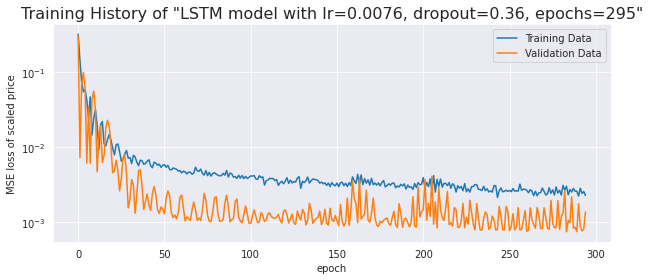

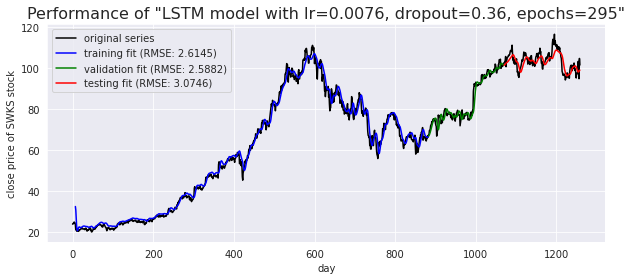

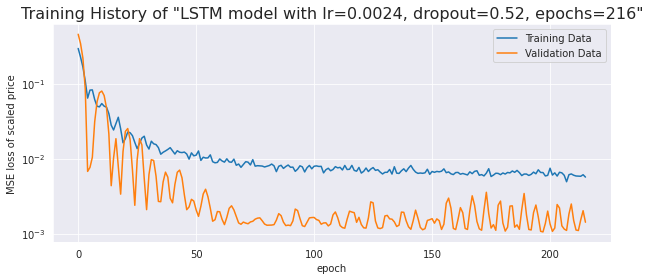

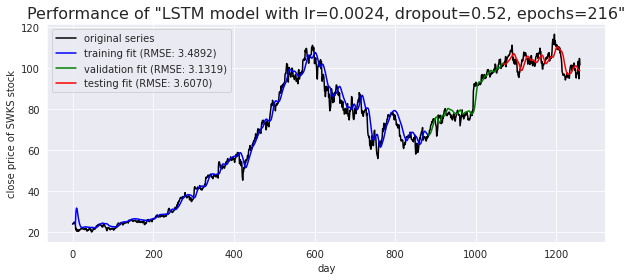

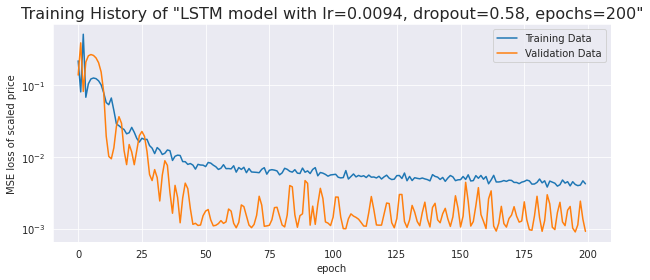

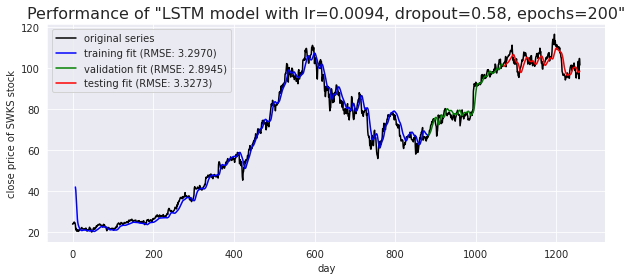

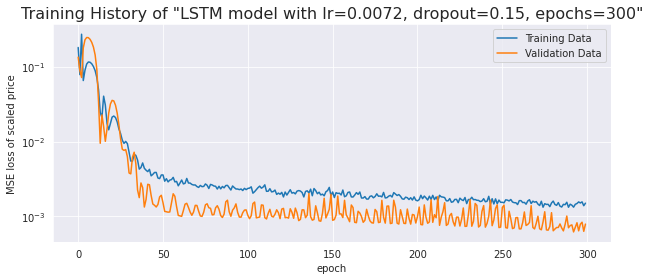

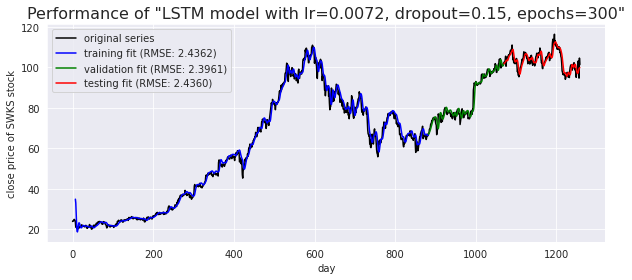

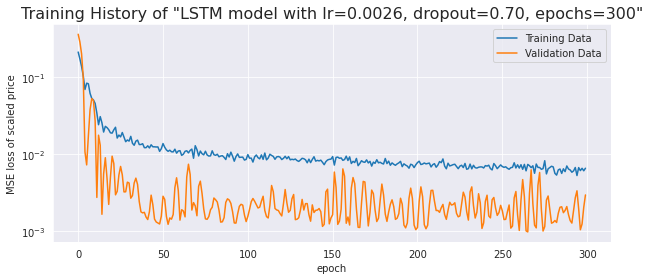

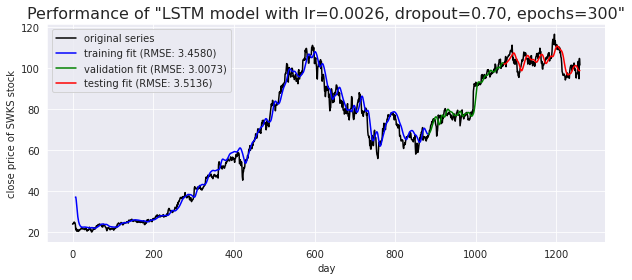

In [ ]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'dropout': (0.1, 0.8), 'lr': (1e-3, 1e-2), 'epochs': (200,300)}

optimizer = BayesianOptimization(
    f=build_obj_func(SWKSclose),
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

optimizer.maximize(init_points=2, n_iter=3,)

print(optimizer.max)

### 3.2.2 Tune Hyper-parameters for Bi-directional LSTM

|   iter    |  target   |  dropout  |  epochs   |    lr     |
-------------------------------------------------------------
epoch 0/295: 
	train loss: 0.2900
	valid loss: 0.1069
epoch 29/295: 
	train loss: 0.0057
	valid loss: 0.0060
epoch 58/295: 
	train loss: 0.0032
	valid loss: 0.0016
epoch 87/295: 
	train loss: 0.0027
	valid loss: 0.0016
epoch 116/295: 
	train loss: 0.0018
	valid loss: 0.0019
epoch 145/295: 
	train loss: 0.0018
	valid loss: 0.0023
epoch 174/295: 
	train loss: 0.0017
	valid loss: 0.0023
epoch 203/295: 
	train loss: 0.0017
	valid loss: 0.0026
epoch 232/295: 
	train loss: 0.0014
	valid loss: 0.0024
epoch 261/295: 
	train loss: 0.0015
	valid loss: 0.0024
epoch 290/295: 
	train loss: 0.0014
	valid loss: 0.0025
|  1        | -0.001472 |  0.3622   |  295.1    |  0.007588 |
epoch 0/216: 
	train loss: 0.1801
	valid loss: 0.1998
epoch 21/216: 
	train loss: 0.0066
	valid loss: 0.0072
epoch 42/216: 
	train loss: 0.0040
	valid loss: 0.0023
epoch 63/216: 
	train loss: 0.0035
	val

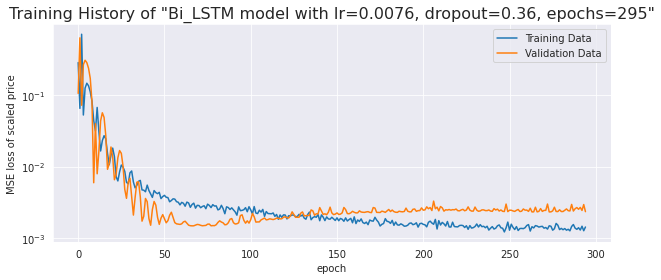

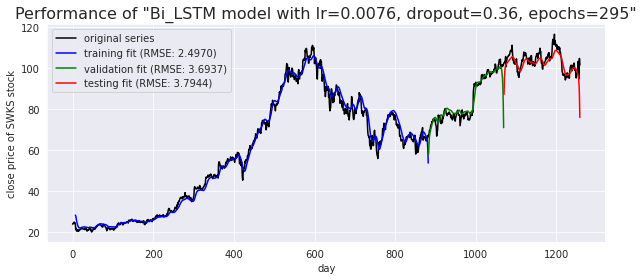

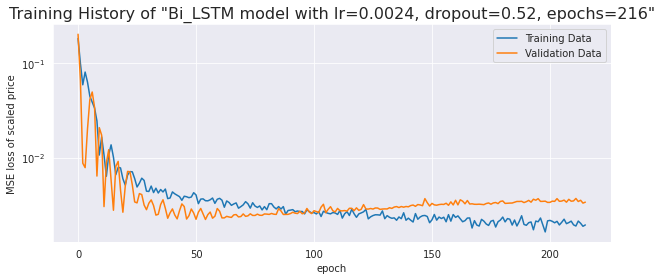

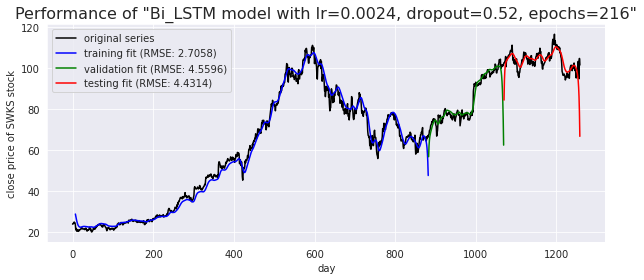

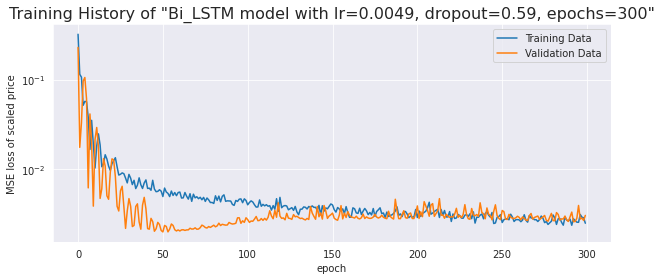

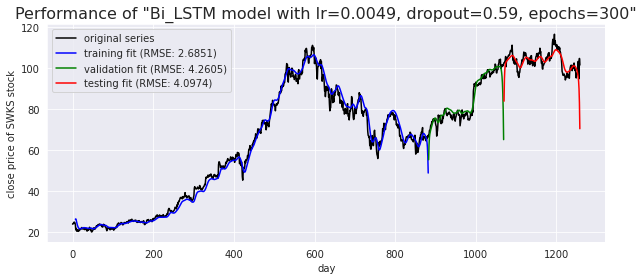

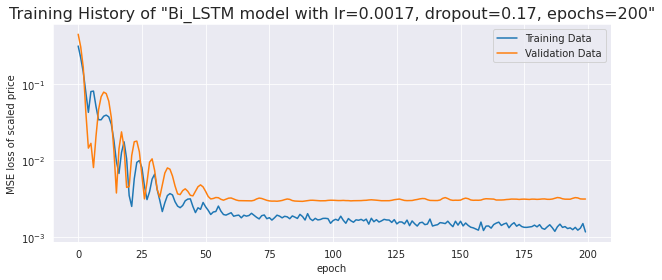

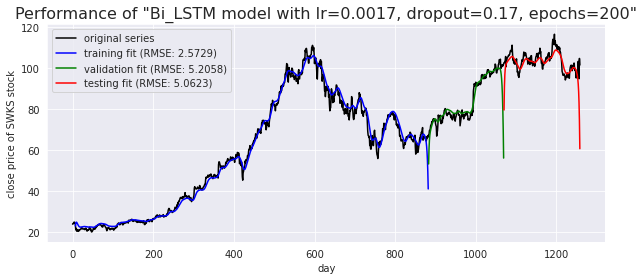

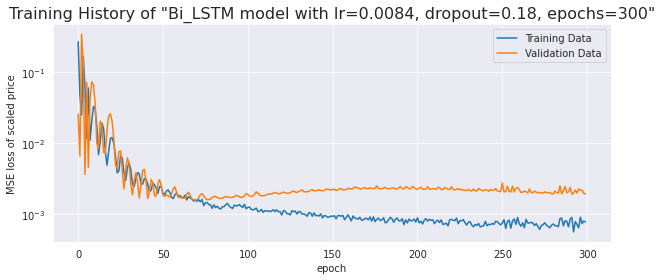

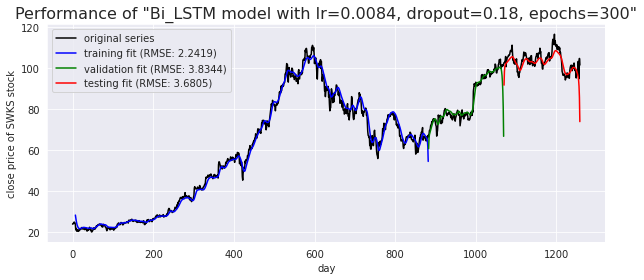

In [ ]:
# Bounded region of parameter space
pbounds = {'dropout': (0.1, 0.8), 'lr': (1e-3, 1e-2), 'epochs': (200,300)}

optimizer = BayesianOptimization(
    f=build_obj_func(SWKSclose, bidirect=True),
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

optimizer.maximize(init_points=2, n_iter=3,)

print(optimizer.max)

## 3.3 Experiment 3: Treat Stock Series as many ngram-length sentences (viewAngle=1)

### 3.3.1 Experimental data

In [ ]:
SWKSclose_Angle1 = expData(stockNM="SWKS", ngram=7, y_len=7, viewAngle=1)

torch.Size([876, 7, 1]) torch.Size([876, 7, 1])
torch.Size([187, 7, 1]) torch.Size([187, 7, 1])
torch.Size([189, 7, 1]) torch.Size([189, 7, 1])


### 3.3.2 Tune Hyper-parameters for one-directional LSTM over SWKS data

|   iter    |  target   |  dropout  |  epochs   |    lr     |
-------------------------------------------------------------
epoch 0/580: 
	train loss: 0.3595
	valid loss: 0.4743
epoch 58/580: 
	train loss: 0.0084
	valid loss: 0.0036
epoch 116/580: 
	train loss: 0.0038
	valid loss: 0.0005
epoch 174/580: 
	train loss: 0.0030
	valid loss: 0.0003
epoch 232/580: 
	train loss: 0.0027
	valid loss: 0.0003
epoch 290/580: 
	train loss: 0.0023
	valid loss: 0.0003
epoch 348/580: 
	train loss: 0.0022
	valid loss: 0.0003
epoch 406/580: 
	train loss: 0.0021
	valid loss: 0.0003
epoch 464/580: 
	train loss: 0.0020
	valid loss: 0.0003
epoch 522/580: 
	train loss: 0.0018
	valid loss: 0.0007
|  1        | -0.000277 |  0.3622   |  580.3    |  0.007588 |
epoch 0/262: 
	train loss: 0.1487
	valid loss: 0.2680
epoch 26/262: 
	train loss: 0.0593
	valid loss: 0.0511
epoch 52/262: 
	train loss: 0.0239
	valid loss: 0.0187
epoch 78/262: 
	train loss: 0.0117
	valid loss: 0.0083
epoch 104/262: 
	train loss: 0.0067
	v

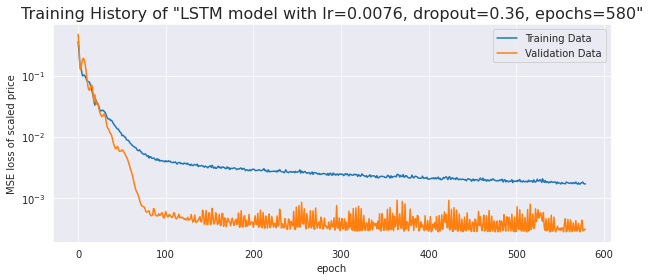

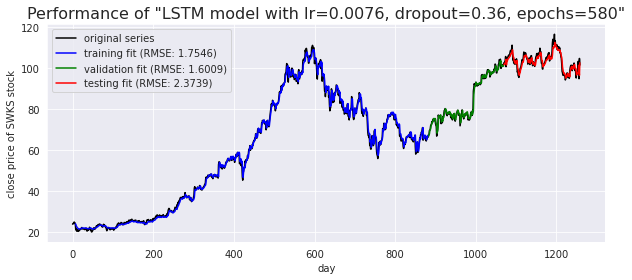

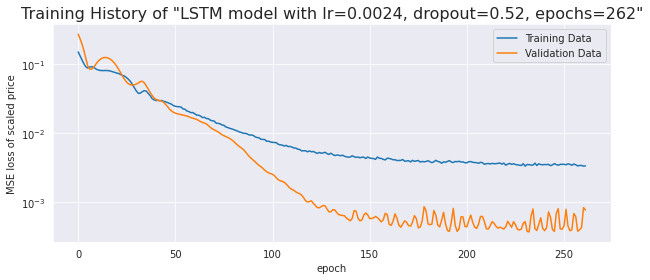

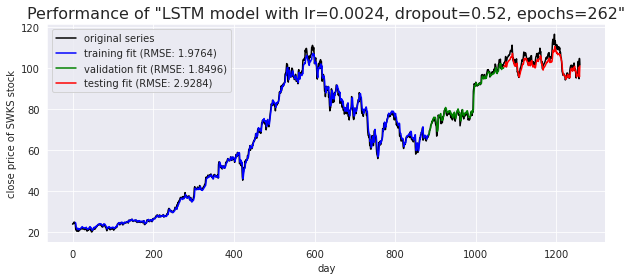

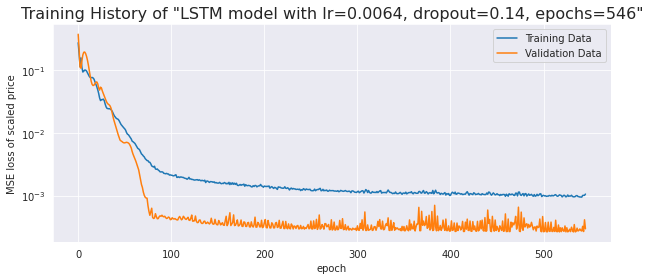

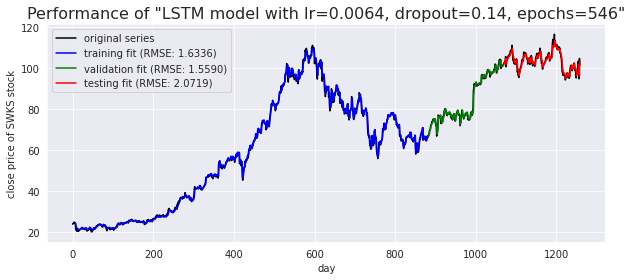

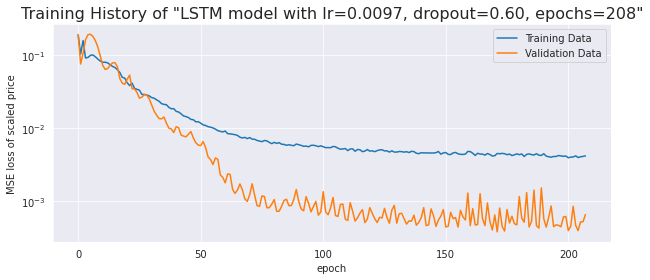

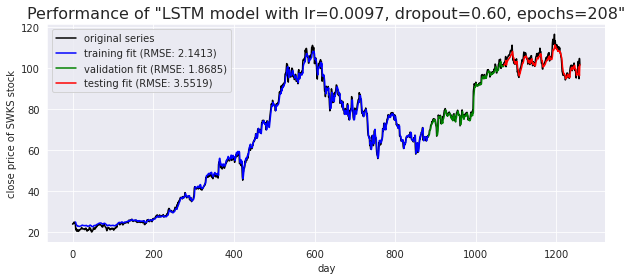

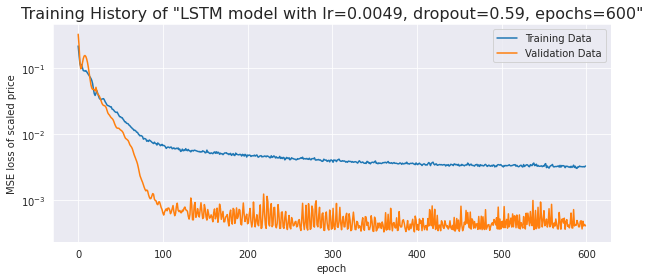

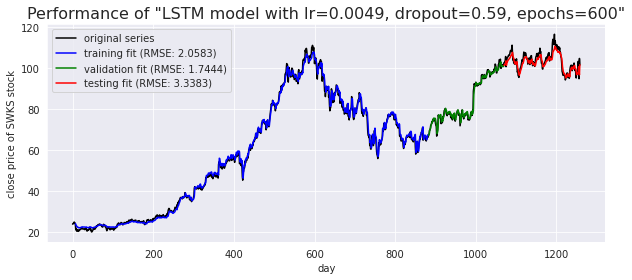

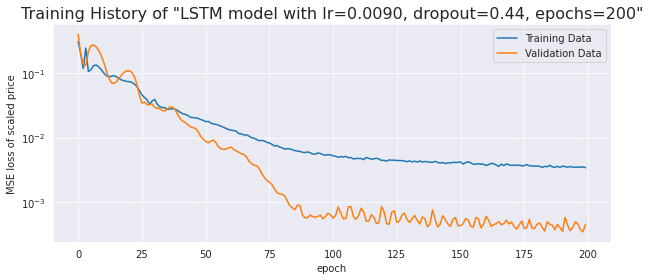

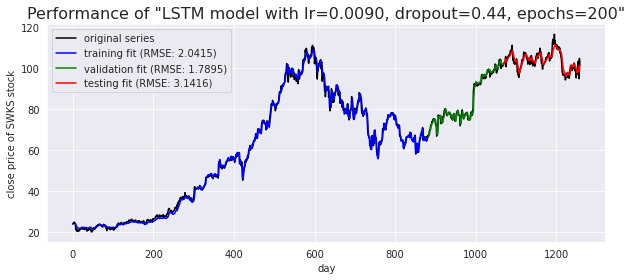

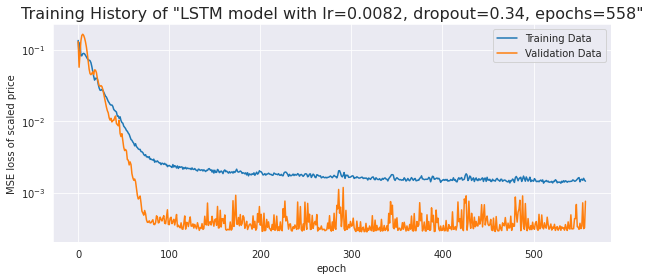

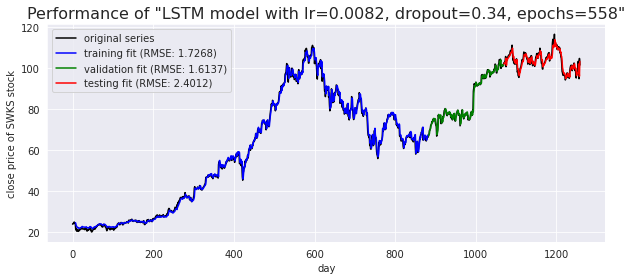

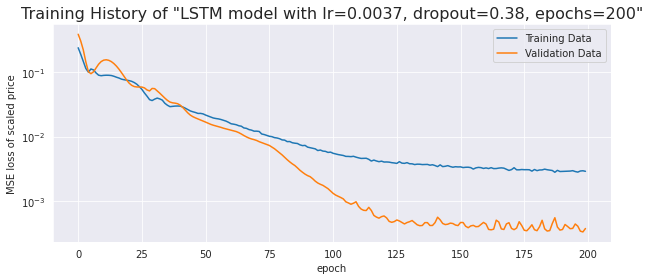

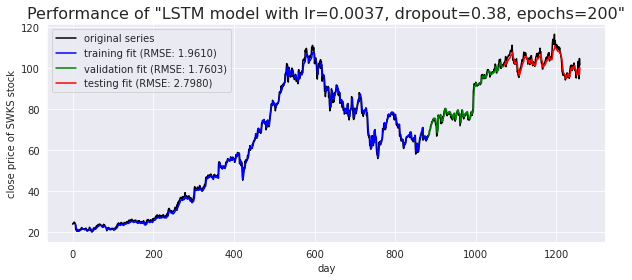

In [ ]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'dropout': (0.1, 0.8), 'lr': (1e-3, 1e-2), 'epochs': (200,600)}

optimizer = BayesianOptimization(
    f=build_obj_func(SWKSclose_Angle1),
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

optimizer.maximize(init_points=4, n_iter=4,)

print(optimizer.max)

### 3.3.3 Tune Hyper-parameters for Bi-directional LSTM over SWKS data

|   iter    |  target   |  dropout  |  epochs   |    lr     |
-------------------------------------------------------------
epoch 0/580: 
	train loss: 0.2095
	valid loss: 0.1505
epoch 58/580: 
	train loss: 0.0028
	valid loss: 0.0005
epoch 116/580: 
	train loss: 0.0016
	valid loss: 0.0004
epoch 174/580: 
	train loss: 0.0015
	valid loss: 0.0004
epoch 232/580: 
	train loss: 0.0013
	valid loss: 0.0003
epoch 290/580: 
	train loss: 0.0012
	valid loss: 0.0003
epoch 348/580: 
	train loss: 0.0012
	valid loss: 0.0004
epoch 406/580: 
	train loss: 0.0010
	valid loss: 0.0003
epoch 464/580: 
	train loss: 0.0010
	valid loss: 0.0004
epoch 522/580: 
	train loss: 0.0009
	valid loss: 0.0003
|  1        | -0.000231 |  0.3622   |  580.3    |  0.007588 |
epoch 0/262: 
	train loss: 0.1712
	valid loss: 0.2514
epoch 26/262: 
	train loss: 0.0132
	valid loss: 0.0072
epoch 52/262: 
	train loss: 0.0045
	valid loss: 0.0017
epoch 78/262: 
	train loss: 0.0035
	valid loss: 0.0005
epoch 104/262: 
	train loss: 0.0030
	v

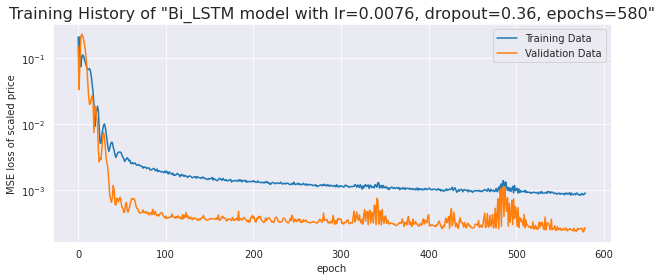

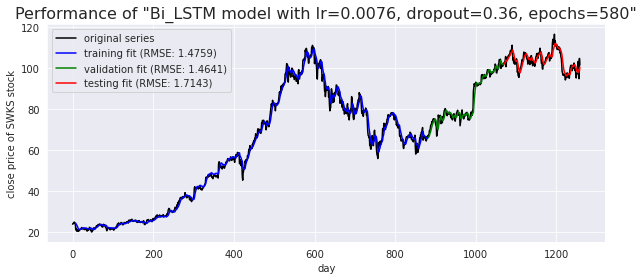

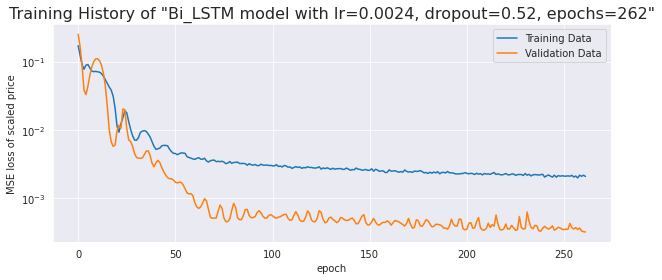

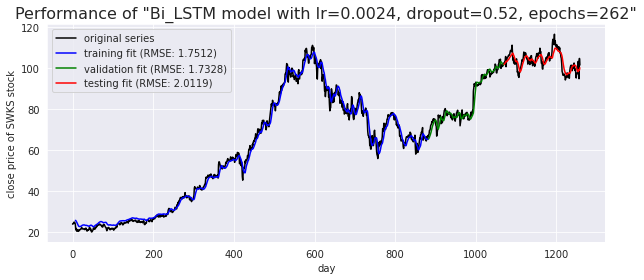

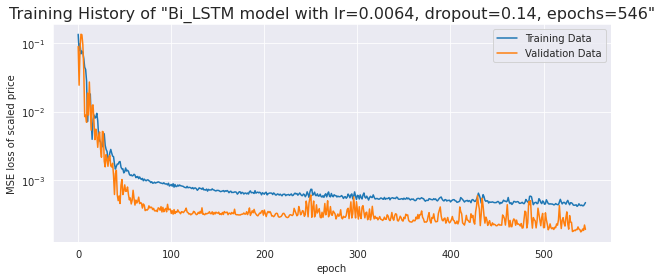

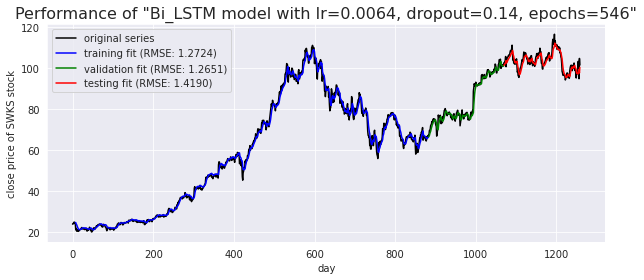

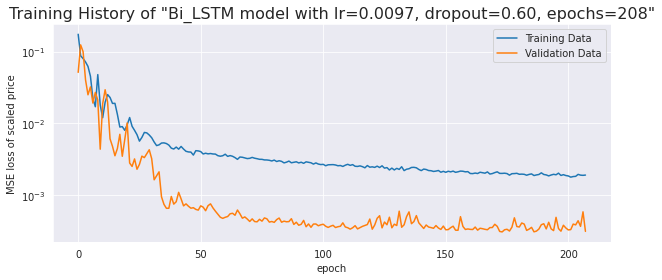

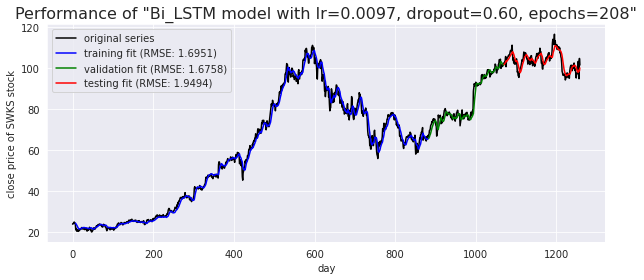

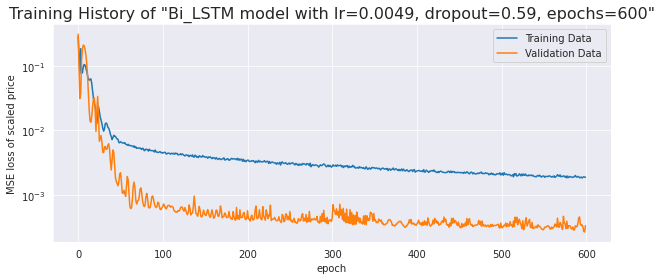

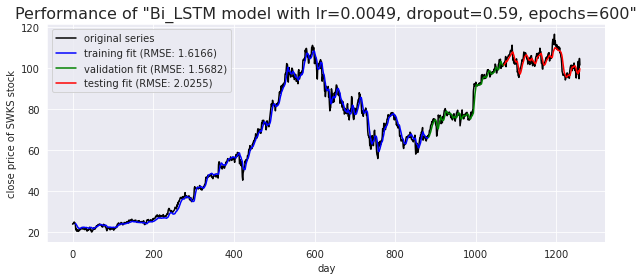

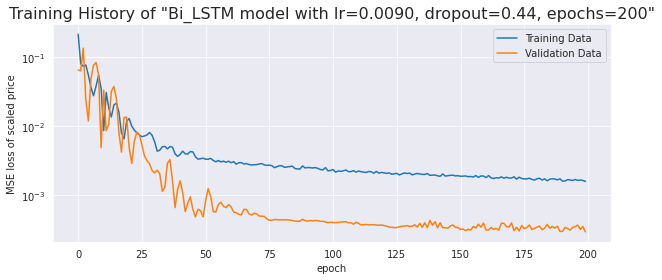

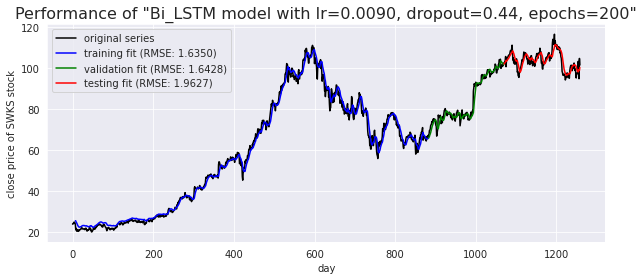

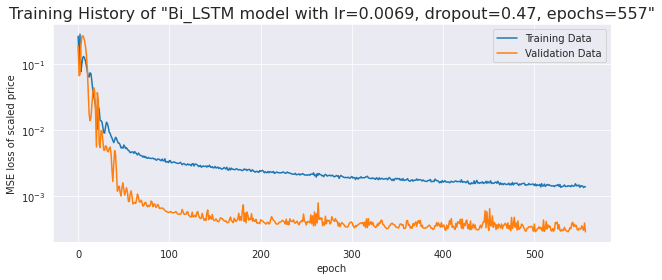

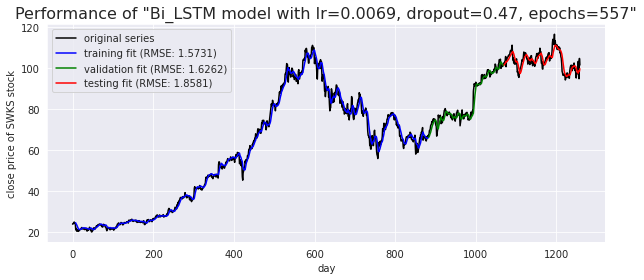

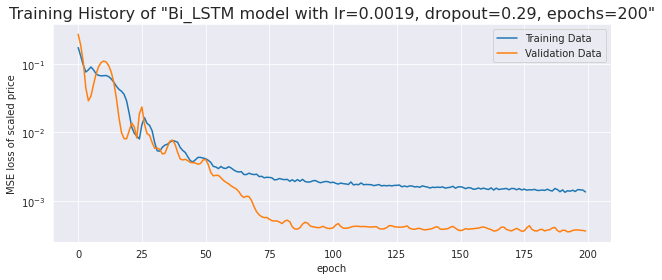

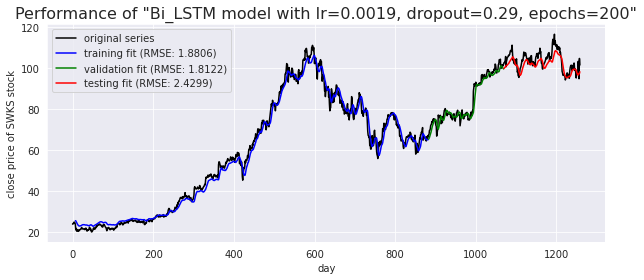

In [ ]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'dropout': (0.1, 0.8), 'lr': (1e-3, 1e-2), 'epochs': (200,600)}

optimizer = BayesianOptimization(
    f=build_obj_func(SWKSclose_Angle1, bidirect=True),
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

optimizer.maximize(init_points=4, n_iter=4,)

print(optimizer.max)

## 3.4 Experiment 4: AAPL stock

### 3.4.1 Experiment data (AAPL stock with viewAngle=0)

In [ ]:
AAPLclose = expData(stockNM="AAPL")

torch.Size([1, 876, 7]) torch.Size([1, 876, 1])
torch.Size([1, 187, 7]) torch.Size([1, 187, 1])
torch.Size([1, 189, 7]) torch.Size([1, 189, 1])


### 3.4.2 Tune Hyper-parameters for one-directional LSTM over AAPL data

|   iter    |  target   |  dropout  |  epochs   |    lr     |
-------------------------------------------------------------
epoch 0/295: 
	train loss: 0.1421
	valid loss: 0.0729
epoch 29/295: 
	train loss: 0.0165
	valid loss: 0.0085
epoch 58/295: 
	train loss: 0.0039
	valid loss: 0.0038
epoch 87/295: 
	train loss: 0.0032
	valid loss: 0.0015
epoch 116/295: 
	train loss: 0.0025
	valid loss: 0.0020
epoch 145/295: 
	train loss: 0.0026
	valid loss: 0.0014
epoch 174/295: 
	train loss: 0.0025
	valid loss: 0.0014
epoch 203/295: 
	train loss: 0.0019
	valid loss: 0.0011
epoch 232/295: 
	train loss: 0.0019
	valid loss: 0.0016
epoch 261/295: 
	train loss: 0.0016
	valid loss: 0.0015
epoch 290/295: 
	train loss: 0.0016
	valid loss: 0.0015
|  1        | -0.000670 |  0.3622   |  295.1    |  0.007588 |
epoch 0/216: 
	train loss: 0.1824
	valid loss: 0.3034
epoch 21/216: 
	train loss: 0.0204
	valid loss: 0.0081
epoch 42/216: 
	train loss: 0.0071
	valid loss: 0.0105
epoch 63/216: 
	train loss: 0.0052
	val

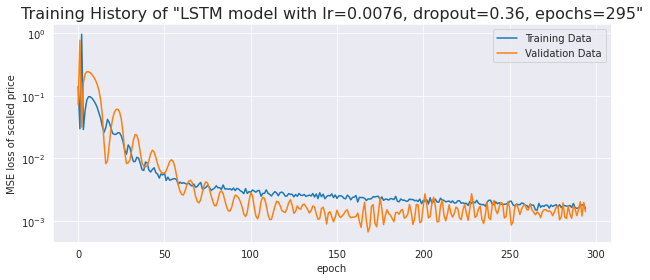

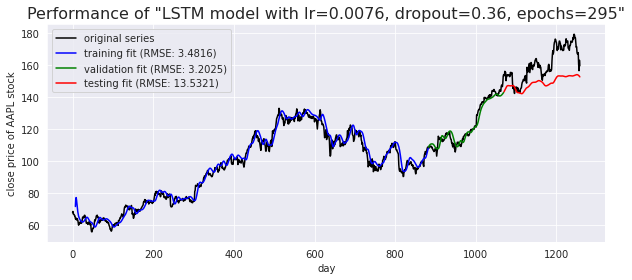

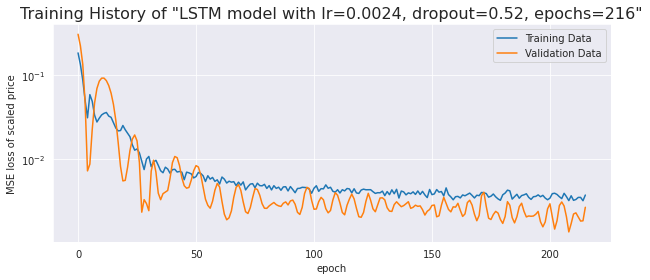

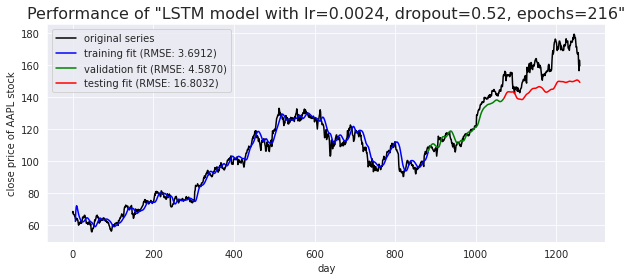

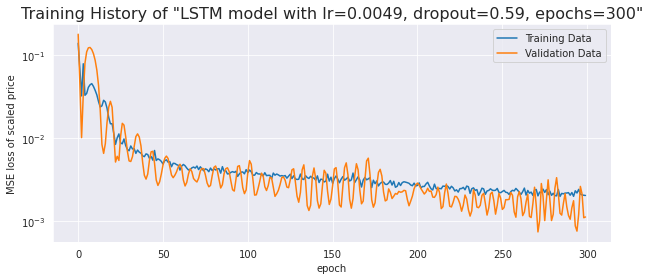

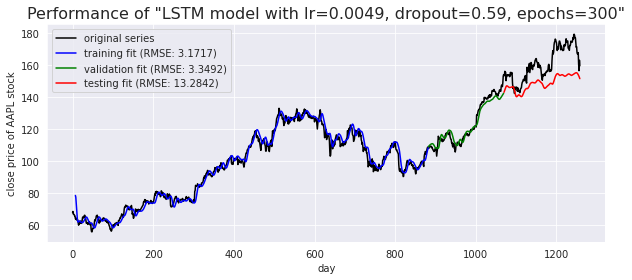

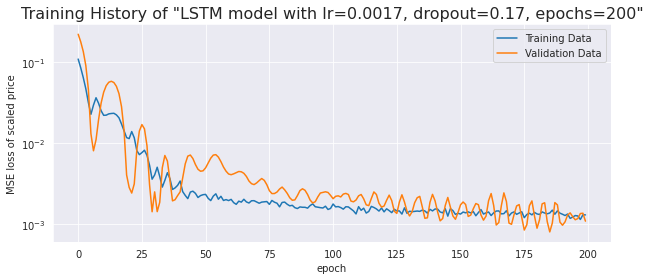

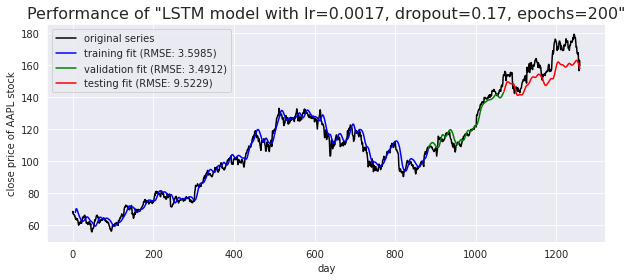

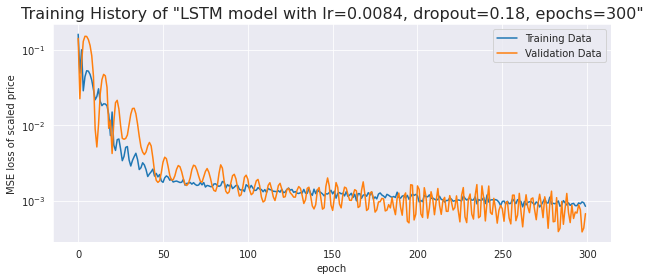

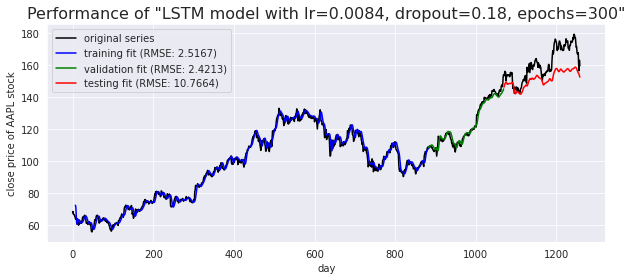

In [ ]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'dropout': (0.1, 0.8), 'lr': (1e-3, 1e-2), 'epochs': (200,300)}

optimizer = BayesianOptimization(
    f=build_obj_func(AAPLclose),
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

optimizer.maximize(init_points=2, n_iter=3,)

print(optimizer.max)

### 3.4.3 Tune Hyper-parameters for Bi-directional LSTM over AAPL data

|   iter    |  target   |  dropout  |  epochs   |    lr     |
-------------------------------------------------------------
epoch 0/295: 
	train loss: 0.1301
	valid loss: 0.0126
epoch 29/295: 
	train loss: 0.0019
	valid loss: 0.0022
epoch 58/295: 
	train loss: 0.0012
	valid loss: 0.0032
epoch 87/295: 
	train loss: 0.0010
	valid loss: 0.0025
epoch 116/295: 
	train loss: 0.0008
	valid loss: 0.0024
epoch 145/295: 
	train loss: 0.0008
	valid loss: 0.0024
epoch 174/295: 
	train loss: 0.0007
	valid loss: 0.0024
epoch 203/295: 
	train loss: 0.0006
	valid loss: 0.0026
epoch 232/295: 
	train loss: 0.0006
	valid loss: 0.0027
epoch 261/295: 
	train loss: 0.0006
	valid loss: 0.0028
epoch 290/295: 
	train loss: 0.0005
	valid loss: 0.0020
|  1        | -0.001389 |  0.3622   |  295.1    |  0.007588 |
epoch 0/216: 
	train loss: 0.0935
	valid loss: 0.1063
epoch 21/216: 
	train loss: 0.0036
	valid loss: 0.0051
epoch 42/216: 
	train loss: 0.0026
	valid loss: 0.0049
epoch 63/216: 
	train loss: 0.0021
	val

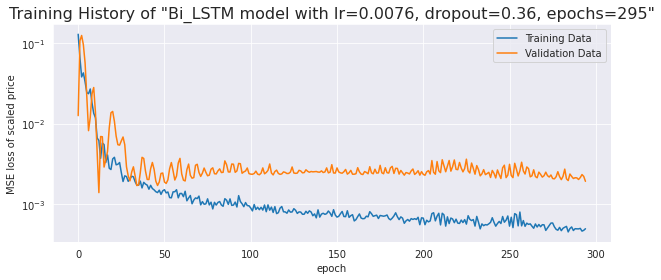

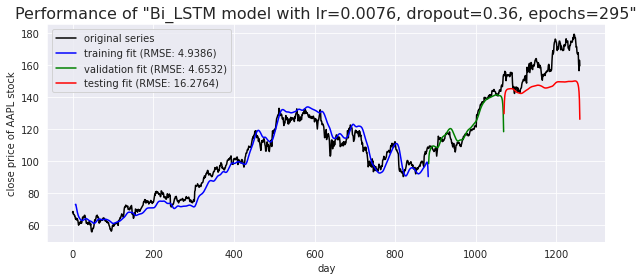

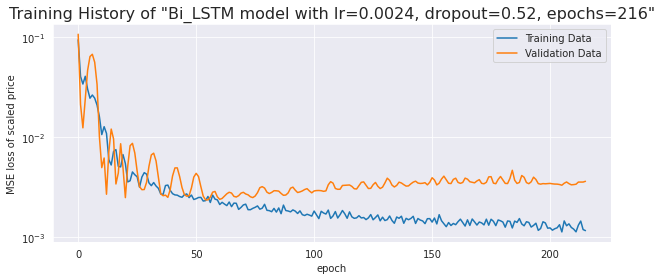

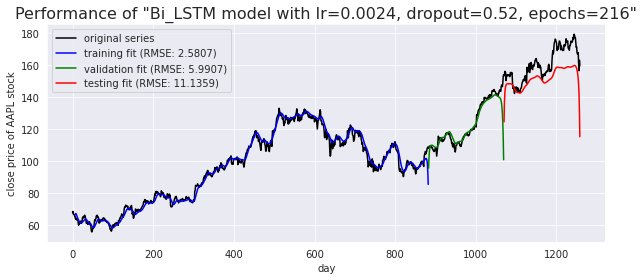

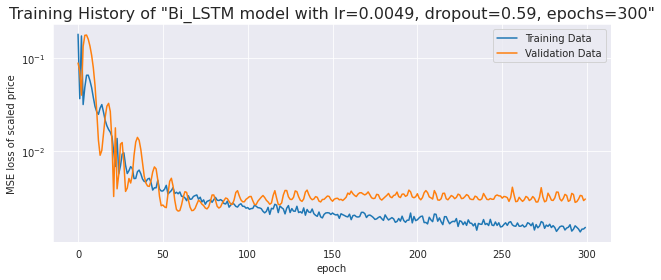

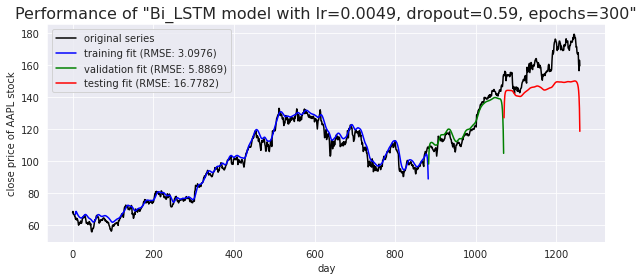

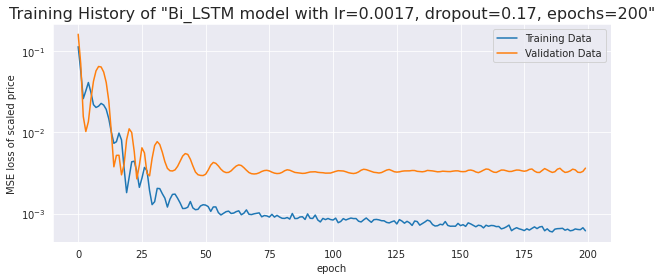

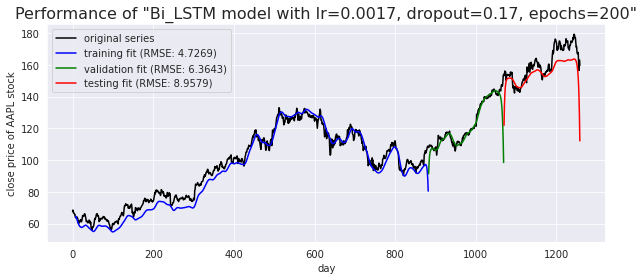

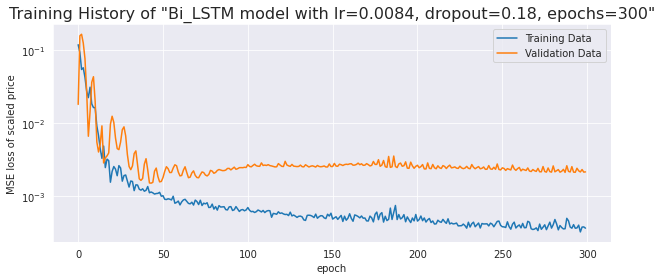

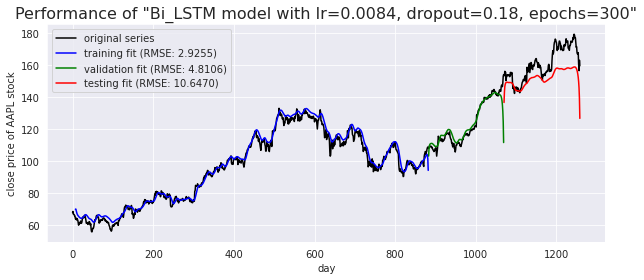

In [ ]:
# Bounded region of parameter space
pbounds = {'dropout': (0.1, 0.8), 'lr': (1e-3, 1e-2), 'epochs': (200,300)}

optimizer = BayesianOptimization(
    f=build_obj_func(AAPLclose, bidirect=True),
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

optimizer.maximize(init_points=2, n_iter=3,)

print(optimizer.max)

### 3.4.4 Experiment data (AAPL stock with viewAngle=1)

In [ ]:
AAPLclose_Angle1 = expData(stockNM="AAPL", ngram=7, y_len=7, viewAngle=1)

torch.Size([876, 7, 1]) torch.Size([876, 7, 1])
torch.Size([187, 7, 1]) torch.Size([187, 7, 1])
torch.Size([189, 7, 1]) torch.Size([189, 7, 1])


### 3.4.5 Tune Hyper-parameters for one-directional LSTM over AAPL data

|   iter    |  target   |  dropout  |  epochs   |    lr     |
-------------------------------------------------------------
epoch 0/580: 
	train loss: 0.1039
	valid loss: 0.1465
epoch 58/580: 
	train loss: 0.0038
	valid loss: 0.0034
epoch 116/580: 
	train loss: 0.0013
	valid loss: 0.0006
epoch 174/580: 
	train loss: 0.0011
	valid loss: 0.0005
epoch 232/580: 
	train loss: 0.0010
	valid loss: 0.0004
epoch 290/580: 
	train loss: 0.0009
	valid loss: 0.0008
epoch 348/580: 
	train loss: 0.0009
	valid loss: 0.0003
epoch 406/580: 
	train loss: 0.0008
	valid loss: 0.0003
epoch 464/580: 
	train loss: 0.0010
	valid loss: 0.0006
epoch 522/580: 
	train loss: 0.0007
	valid loss: 0.0005
|  1        | -0.000260 |  0.3622   |  580.3    |  0.007588 |
epoch 0/262: 
	train loss: 0.1382
	valid loss: 0.2570
epoch 26/262: 
	train loss: 0.0359
	valid loss: 0.0599
epoch 52/262: 
	train loss: 0.0158
	valid loss: 0.0287
epoch 78/262: 
	train loss: 0.0111
	valid loss: 0.0131
epoch 104/262: 
	train loss: 0.0073
	v

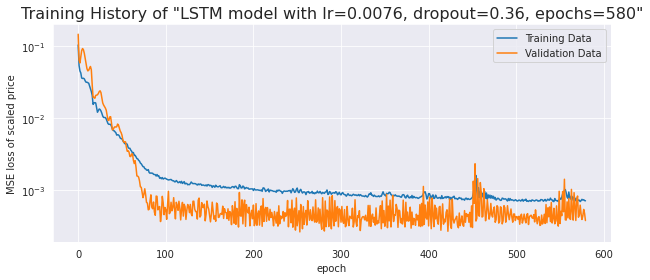

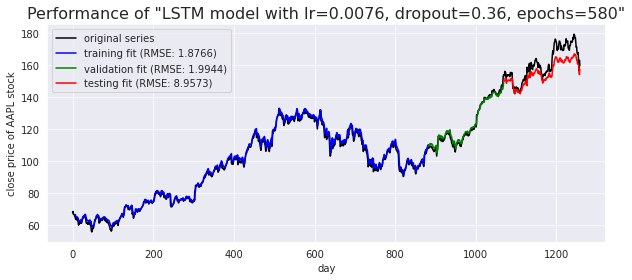

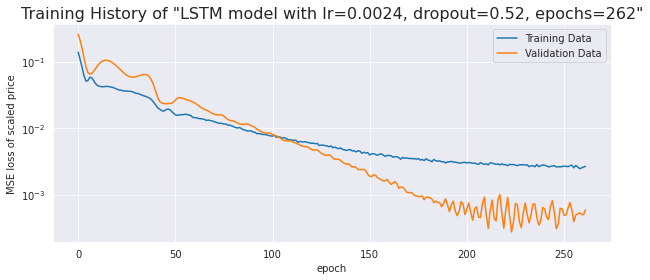

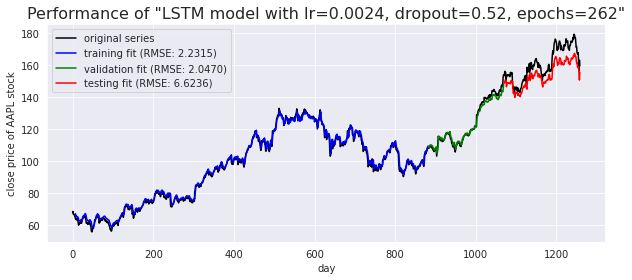

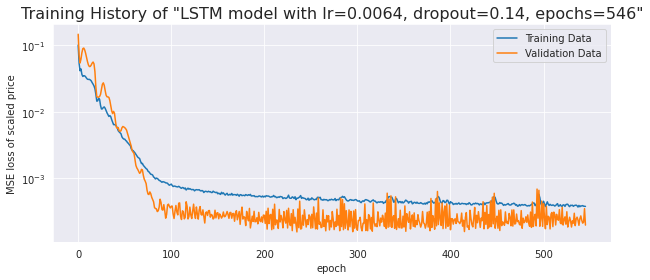

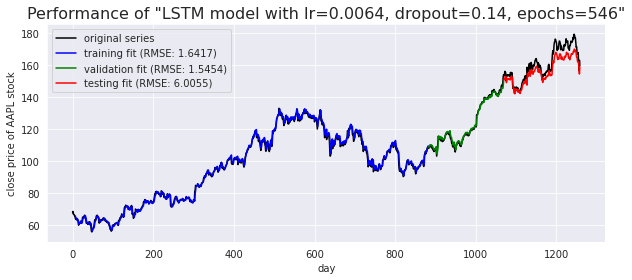

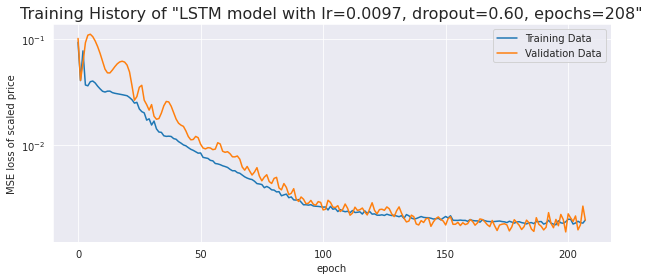

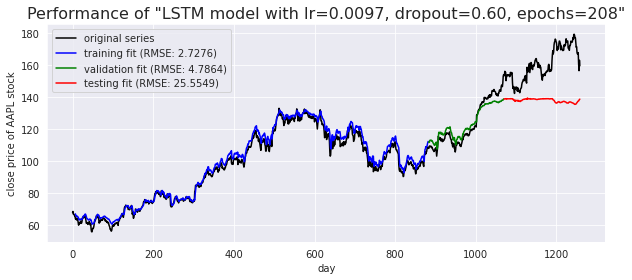

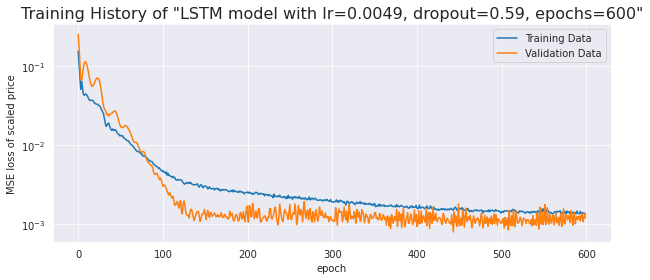

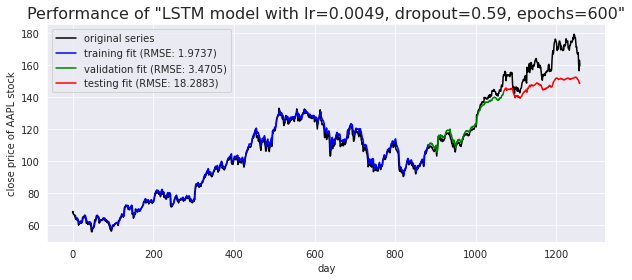

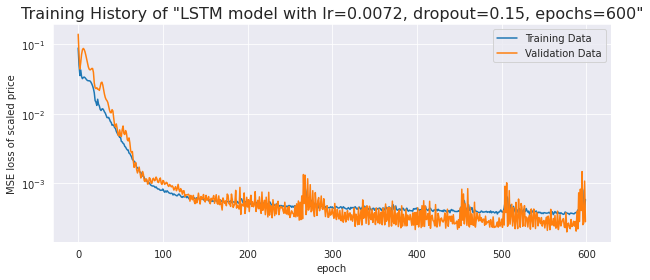

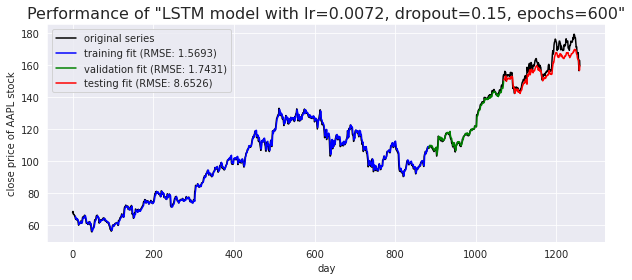

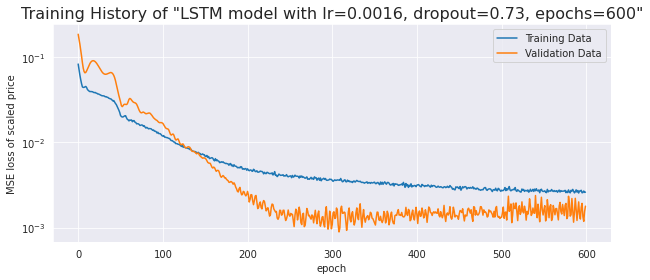

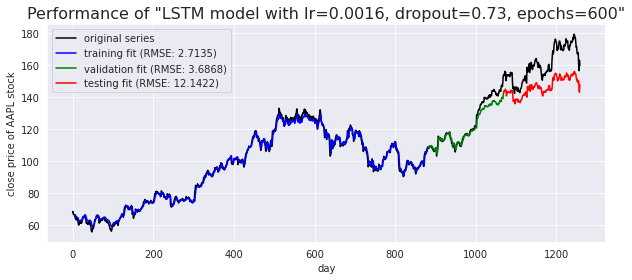

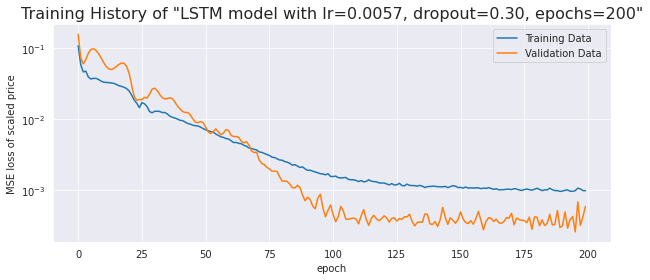

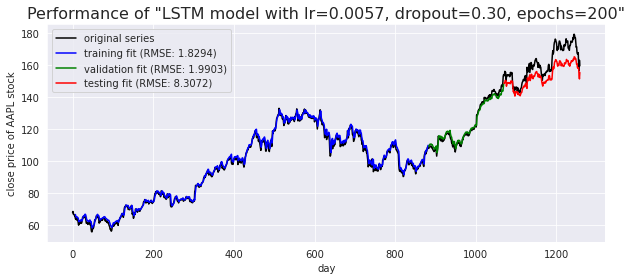

In [ ]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'dropout': (0.1, 0.8), 'lr': (1e-3, 1e-2), 'epochs': (200,600)}

optimizer = BayesianOptimization(
    f=build_obj_func(AAPLclose_Angle1),
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

optimizer.maximize(init_points=4, n_iter=4,)

print(optimizer.max)

### 3.4.6 Tune Hyper-parameters for Bi-directional LSTM over AAPL data

|   iter    |  target   |  dropout  |  epochs   |    lr     |
-------------------------------------------------------------
epoch 0/580: 
	train loss: 0.2048
	valid loss: 0.1330
epoch 58/580: 
	train loss: 0.0022
	valid loss: 0.0017
epoch 116/580: 
	train loss: 0.0013
	valid loss: 0.0010
epoch 174/580: 
	train loss: 0.0010
	valid loss: 0.0006
epoch 232/580: 
	train loss: 0.0009
	valid loss: 0.0004
epoch 290/580: 
	train loss: 0.0008
	valid loss: 0.0005
epoch 348/580: 
	train loss: 0.0007
	valid loss: 0.0004
epoch 406/580: 
	train loss: 0.0007
	valid loss: 0.0006
epoch 464/580: 
	train loss: 0.0006
	valid loss: 0.0003
epoch 522/580: 
	train loss: 0.0006
	valid loss: 0.0004
|  1        | -0.000276 |  0.3622   |  580.3    |  0.007588 |
epoch 0/262: 
	train loss: 0.1972
	valid loss: 0.3006
epoch 26/262: 
	train loss: 0.0233
	valid loss: 0.0415
epoch 52/262: 
	train loss: 0.0054
	valid loss: 0.0036
epoch 78/262: 
	train loss: 0.0028
	valid loss: 0.0008
epoch 104/262: 
	train loss: 0.0024
	v

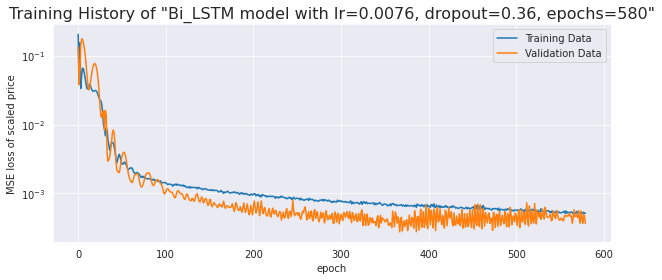

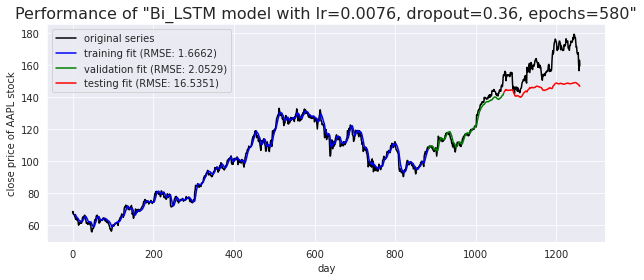

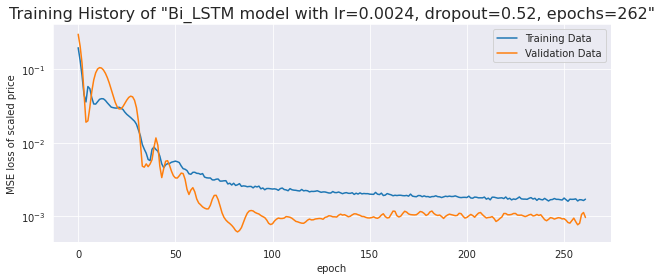

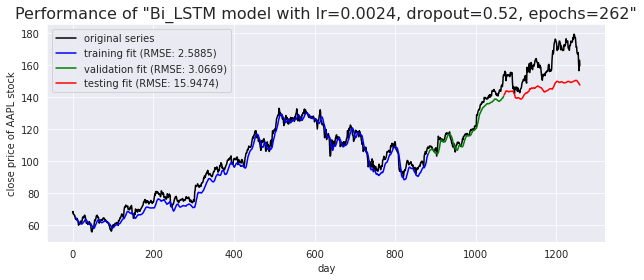

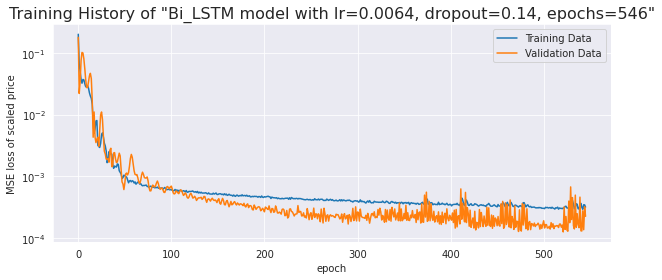

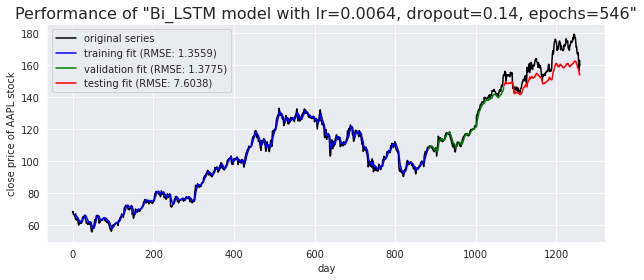

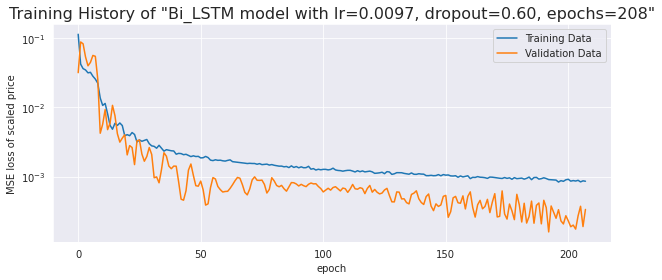

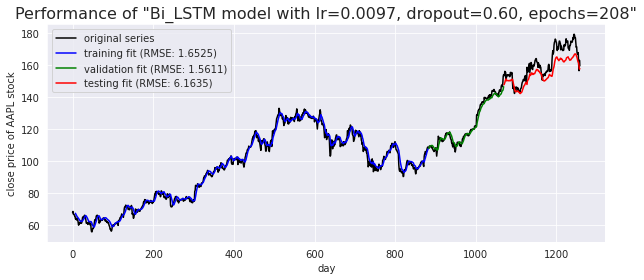

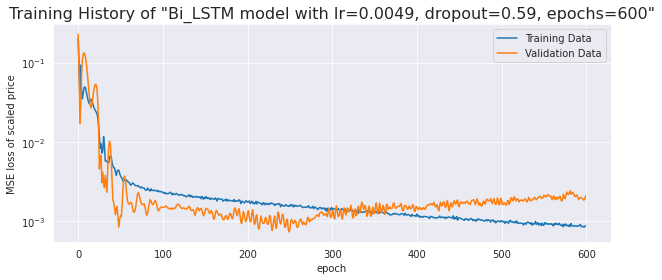

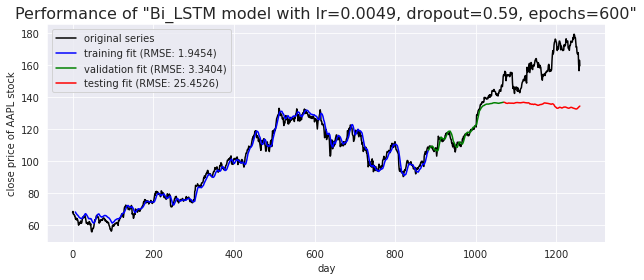

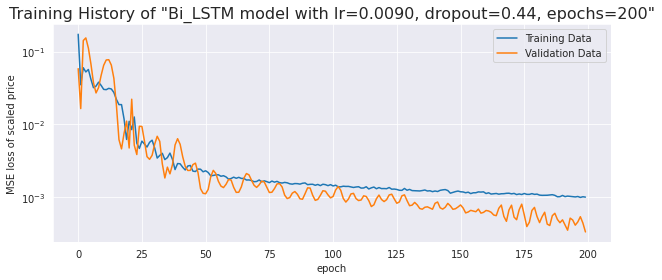

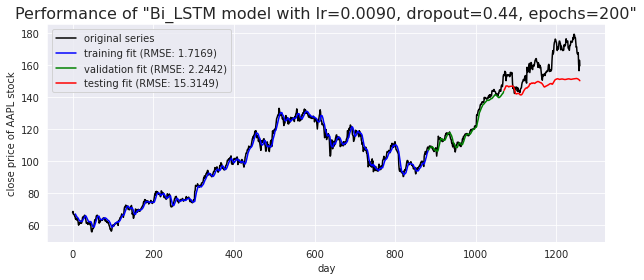

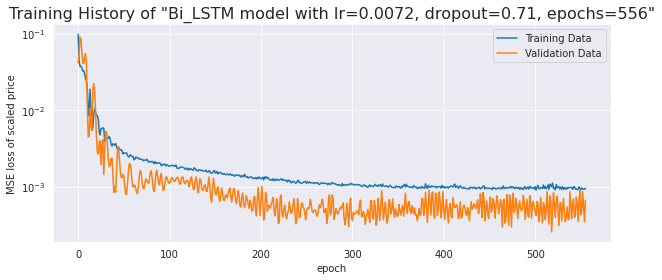

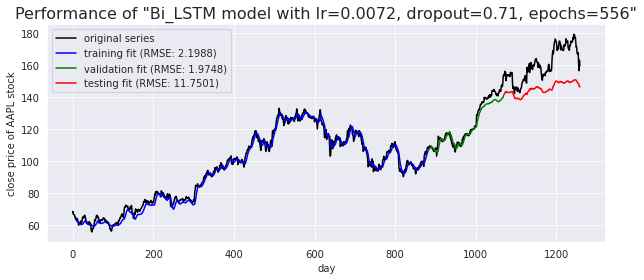

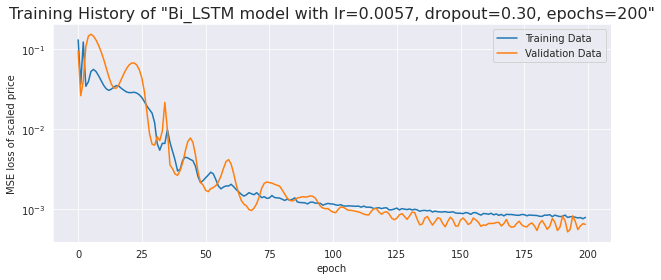

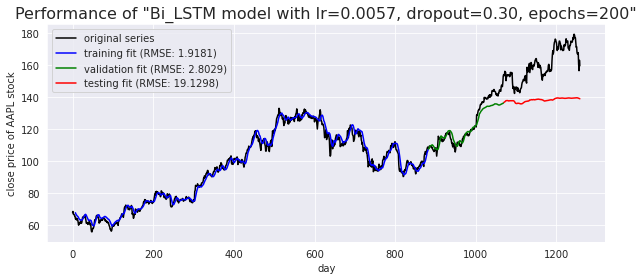

In [ ]:
# Bounded region of parameter space
pbounds = {'dropout': (0.1, 0.8), 'lr': (1e-3, 1e-2), 'epochs': (200,600)}

optimizer = BayesianOptimization(
    f=build_obj_func(AAPLclose_Angle1, bidirect=True),
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

optimizer.maximize(init_points=4, n_iter=4,)

print(optimizer.max)